## MNIST

In [2]:
from __future__ import print_function
import tensorflow as tf

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

# Training Parameters
learning_rate = 0.001
training_steps = 2000
batch_size = 128
display_step = 200

# Network Parameters
num_input = 28 # MNIST data input (img shape: 28*28)
timesteps = 28 # timesteps
num_hidden = 128 # hidden layer num of features
num_classes = 10 # MNIST total classes (0-9 digits)
tf.reset_default_graph()

# tf Graph input
X = tf.placeholder("float", [None, timesteps, num_input])
Y = tf.placeholder("float", [None, num_classes])


# Define weights
weights = {
    'out': tf.Variable(tf.random_normal([num_hidden, num_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([num_classes]))
}

def RNN(x, weights, biases):


    # Define a cell with tensorflow
    cell=tf.contrib.rnn.BasicRNNCell(num_hidden)
    #cell = tf.contrib.rnn.LSTMCell(num_hidden, state_is_tuple=True)
    #cell = tf.contrib.rnn.GRUCell(num_hidden)
    
    ## switch to multiple layer RNN
    #cell = tf.nn.rnn_cell.MultiRNNCell([tf.contrib.rnn.BasicRNNCell(num_hidden) for _ in range(3)])
    
    init_state = cell.zero_state(batch_size, dtype=tf.float32)
    
    # Get cell output
    
    #if inputs is (batches, steps, inputs) ==> time_major=False
    #if inputs is (steps, batches, inputs) ==> time_major=True
    #state_is_tuple = Treu mean output of dynamic_rnn is (c_state, h_state)
    
    outputs, final_state = tf.nn.dynamic_rnn(cell, x, initial_state=init_state, time_major=False)
    # change outputs to list [(batch, outputs)..] * steps
    outputs = tf.unstack(tf.transpose(outputs, [1,0,2]))
    # Linear activation, using rnn inner loop last output
    return tf.matmul(outputs[-1], weights['out']) + biases['out']

logits = RNN(X, weights, biases)
#prediction = tf.nn.softmax(logits)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model (with test logits, for dropout to be disabled)
correct_pred = tf.equal(tf.argmax(logits , 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(tf.global_variables_initializer())

    for step in range(1, training_steps+1):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Reshape data to get 28 seq of 28 elements
        batch_x = batch_x.reshape((batch_size, timesteps, num_input))
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                 Y: batch_y})
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc))

    print("Optimization Finished!")

    # Calculate accuracy for 128 mnist test images
    test_len = 128
    test_data = mnist.test.images[:test_len].reshape((-1, timesteps, num_input))
    test_label = mnist.test.labels[:test_len]
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={X: test_data, Y: test_label}))


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Step 1, Minibatch Loss= 4.2888, Training Accuracy= 0.156
Step 200, Minibatch Loss= 1.1738, Training Accuracy= 0.555
Step 400, Minibatch Loss= 0.7560, Training Accuracy= 0.773
Step 600, Minibatch Loss= 0.8312, Training Accuracy= 0.750
Step 800, Minibatch Loss= 0.5868, Training Accuracy= 0.828
Step 1000, Minibatch Loss= 0.6832, Training Accuracy= 0.773
Step 1200, Minibatch Loss= 0.4905, Training Accuracy= 0.852
Step 1400, Minibatch Loss= 0.5748, Training Accuracy= 0.828
Step 1600, Minibatch Loss= 0.4601, Training Accuracy= 0.875
Step 1800, Minibatch Loss= 0.6832, Training Accuracy= 0.805
Step 2000, Minibatch Loss= 0.4694, Training Accuracy= 0.875
Optimization Finished!
Testing Accuracy: 0.890625


## Word2Vect 

In [4]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filename)
    else:
        print(statinfo.st_size)
        raise Exception(
        'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('text8.zip', 31344016)

def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data
  
words = read_data(filename)
print('Data size %d' % len(words))

vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Found and verified text8.zip
Data size 17005207
Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5237, 3084, 12, 6, 195, 2, 3136, 46, 59, 156]


In [5]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'originated', 'a', 'as', 'term', 'of', 'a']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['originated', 'anarchism', 'term', 'a', 'term', 'originated', 'of', 'as']


In [6]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
    # Variables.
    embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [7]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(
            batch_size, num_skips, skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
              # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.497978
Nearest to so: colonels, hampering, medications, armor, wave, opel, azariah, engendered,
Nearest to two: yousef, fulbright, engineered, vanity, licensees, http, ij, devlin,
Nearest to called: fanfiction, roleplaying, jamaican, brabham, drinkordie, cerberus, gaining, goi,
Nearest to UNK: preaching, tenth, bizkit, inmate, prat, maneaba, germanium, amenable,
Nearest to that: halloween, telangana, summarised, mmc, indicating, macias, guinness, ordinated,
Nearest to world: jets, disruption, prinz, majesty, gunboats, hark, milliardo, gaians,
Nearest to first: supposing, maternal, perspectives, litt, deduces, buying, moments, latinos,
Nearest to such: khanates, indisputable, dizziness, diner, goguryeo, handed, deviant, ferries,
Nearest to th: walker, tas, inheritance, allman, nc, intersection, berth, hanging,
Nearest to for: protons, varied, orca, fixation, cker, contend, spiders, pronouns,
Nearest to see: lv, reprise, planners, normalcy, wears, me

Average loss at step 52000: 3.439477
Average loss at step 54000: 3.429768
Average loss at step 56000: 3.444685
Average loss at step 58000: 3.394957
Average loss at step 60000: 3.392905
Nearest to so: if, galante, too, imre, thus, hearing, barcode, microscopic,
Nearest to two: three, four, six, one, five, seven, eight, nine,
Nearest to called: named, scudetto, used, aloes, cta, shem, belgians, martingale,
Nearest to UNK: wye, hepburn, realms, nibelungenlied, interpretations, resided, nocs, infield,
Nearest to that: which, however, what, this, there, who, it, where,
Nearest to world: interiors, boer, modifying, fighting, counterrevolutionary, spark, madeira, beira,
Nearest to first: second, last, next, final, same, latter, best, third,
Nearest to such: well, these, known, many, certain, including, regarded, deviant,
Nearest to th: bc, six, five, nc, four, axial, eight, motto,
Nearest to for: without, kate, of, joss, including, luening, if, in,
Nearest to see: cactus, list, include, can, 

In [8]:

num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

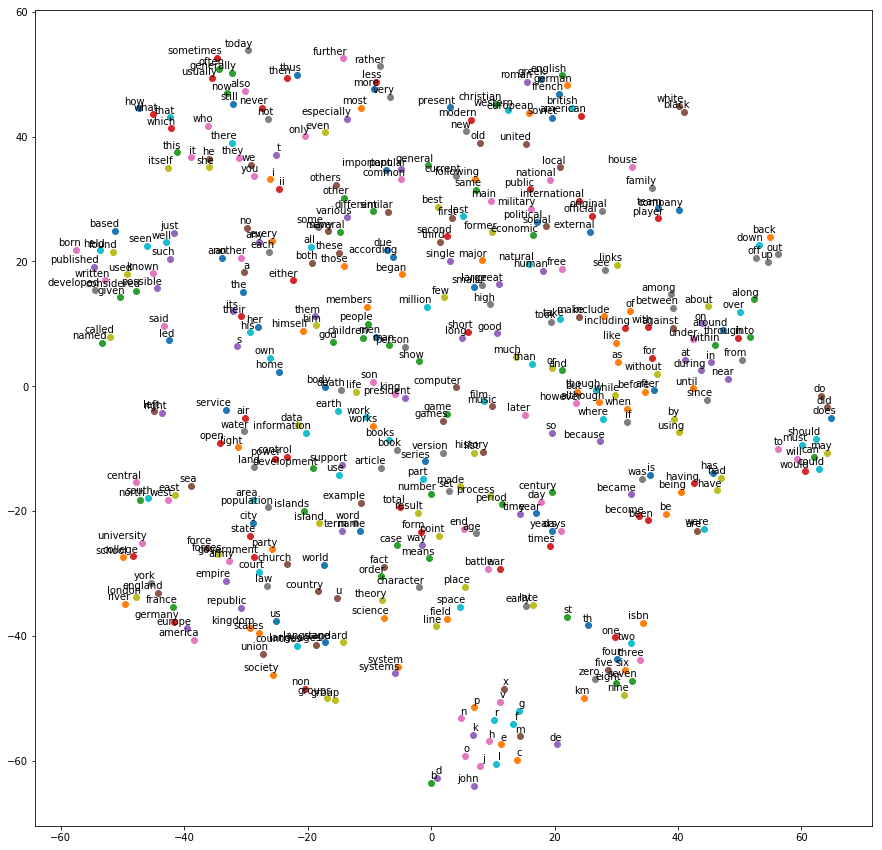

In [9]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                        ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

## Many to one RNN 

In [25]:
import os
import re
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from zipfile import ZipFile

tf.reset_default_graph()

# Set RNN parameters
epochs = 30
batch_size = 32
max_sequence_length = 25
rnn_size = 10
embedding_size = 50
min_word_frequency = 10
learning_rate = 0.0005

# Download or open data
data_dir = 'temp'
data_file = 'text_data.txt'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

if not os.path.isfile(os.path.join(data_dir, data_file)):
    zip_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    r = requests.get(zip_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read('SMSSpamCollection')
    # Format Data
    text_data = file.decode()
    text_data = text_data.encode('ascii',errors='ignore')
    text_data = text_data.decode().split('\n')

    # Save data to text file
    with open(os.path.join(data_dir, data_file), 'w') as file_conn:
        for text in text_data:
            file_conn.write("{}\n".format(text))
else:
    # Open data from text file
    text_data = []
    with open(os.path.join(data_dir, data_file), 'r') as file_conn:
        for row in file_conn:
            text_data.append(row)
    text_data = text_data[:-1]

text_data = [x.split('\t') for x in text_data if len(x)>=1]
[text_data_target, text_data_train] = [list(x) for x in zip(*text_data)]

for i in range(5):
    print('i = {} \ntext_data_target: {} \ntext_data_train: {}'.format(i, text_data_target[i], text_data_train[i]))
    

i = 0 
text_data_target: ham 
text_data_train: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

i = 1 
text_data_target: ham 
text_data_train: Ok lar... Joking wif u oni...

i = 2 
text_data_target: spam 
text_data_train: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

i = 3 
text_data_target: ham 
text_data_train: U dun say so early hor... U c already then say...

i = 4 
text_data_target: ham 
text_data_train: Nah I don't think he goes to usf, he lives around here though



In [26]:
# Create a text cleaning function
def clean_text(text_string):
    text_string = re.sub(r'([^\s\w]|_|[0-9])+', '', text_string)
    text_string = " ".join(text_string.split())
    text_string = text_string.lower()
    return(text_string)

# Clean texts
text_data_train = [clean_text(x) for x in text_data_train]

# print first 10 text data
for i in range(10):
    print(text_data_train[i])

vocab_processor = tf.contrib.learn.preprocessing.VocabularyProcessor(max_sequence_length,
                                                                     min_frequency=min_word_frequency)
text_processed = np.array(list(vocab_processor.fit_transform(text_data_train)))

print('=================')

for i in range(5):
    print(text_processed[i])

go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
ok lar joking wif u oni
free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry questionstd txt ratetcs apply overs
u dun say so early hor u c already then say
nah i dont think he goes to usf he lives around here though
freemsg hey there darling its been weeks now and no word back id like some fun you up for it still tb ok xxx std chgs to send to rcv
even my brother is not like to speak with me they treat me like aids patent
as per your request melle melle oru minnaminunginte nurungu vettam has been set as your callertune for all callers press to copy your friends callertune
winner as a valued network customer you have been selected to receivea prize reward to claim call claim code kl valid hours only
had your mobile months or more u r entitled to update to the latest colour mobiles with camera for free call the mobile update co free on
[ 44 455   0 809 7

In [27]:
# Shuffle and split data
text_processed = np.array(text_processed)
text_data_target = np.array([1 if x=='ham' else 0 for x in text_data_target])
shuffled_ix = np.random.permutation(np.arange(len(text_data_target)))
x_shuffled = text_processed[shuffled_ix]
y_shuffled = text_data_target[shuffled_ix]

# Split train/test set
ix_cutoff = int(len(y_shuffled)*0.80)
x_train, x_test = x_shuffled[:ix_cutoff], x_shuffled[ix_cutoff:]
y_train, y_test = y_shuffled[:ix_cutoff], y_shuffled[ix_cutoff:]
vocab_size = len(vocab_processor.vocabulary_)
print("Vocabulary Size: {:d}".format(vocab_size))
print("80-20 Train Test split: {:d} -- {:d}".format(len(y_train), len(y_test)))


Vocabulary Size: 933
80-20 Train Test split: 4459 -- 1115


In [28]:
# Create placeholders
x_data = tf.placeholder(tf.int32, [None, max_sequence_length])
y_output = tf.placeholder(tf.int32, [None])
dropout_keep_prob = tf.placeholder(tf.float32)

# Create embedding
embedding_mat = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0))
embedding_output = tf.nn.embedding_lookup(embedding_mat, x_data)

cell=tf.contrib.rnn.BasicRNNCell(num_units = rnn_size)
#cell = tf.contrib.rnn.LSTMCell(rnn_size, state_is_tuple=True)
#cell = tf.contrib.rnn.GRUCell(rnn_size)


output, state = tf.nn.dynamic_rnn(cell, embedding_output, dtype=tf.float32)
output = tf.nn.dropout(output, dropout_keep_prob)

# Get output of RNN sequence

output = tf.unstack(tf.transpose(output, [1,0,2]))
last = output[-1]

weight = tf.Variable(tf.truncated_normal([rnn_size, 2], stddev=0.1))
bias = tf.Variable(tf.constant(0.1, shape=[2]))
logits_out = tf.matmul(last, weight) + bias

# Loss function
losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_out, labels=y_output) # logits=float32, labels=int32
loss = tf.reduce_mean(losses)
train_step = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits_out, 1), tf.cast(y_output, tf.int64)), tf.float32))




In [29]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()

    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    # Start training
    for epoch in range(epochs):

        # Shuffle training data
        shuffled_ix = np.random.permutation(np.arange(len(x_train)))
        x_train = x_train[shuffled_ix]
        y_train = y_train[shuffled_ix]
        num_batches = int(len(x_train)/batch_size) + 1
        # TO DO CALCULATE GENERATIONS ExACTLY
        for i in range(num_batches):
            # Select train data
            min_ix = i * batch_size
            max_ix = np.min([len(x_train), ((i+1) * batch_size)])
            x_train_batch = x_train[min_ix:max_ix]
            y_train_batch = y_train[min_ix:max_ix]

            # Run train step
            train_dict = {x_data: x_train_batch, y_output: y_train_batch, dropout_keep_prob:0.5}
            sess.run(train_step, feed_dict=train_dict)

        # Run loss and accuracy for training
        temp_train_loss, temp_train_acc = sess.run([loss, accuracy], feed_dict=train_dict)
        train_loss.append(temp_train_loss)
        train_accuracy.append(temp_train_acc)

        # Run Eval Step
        test_dict = {x_data: x_test, y_output: y_test, dropout_keep_prob:1.0}
        temp_test_loss, temp_test_acc = sess.run([loss, accuracy], feed_dict=test_dict)
        test_loss.append(temp_test_loss)
        test_accuracy.append(temp_test_acc)
        print('Epoch: {}, Test Loss: {:.2}, Test Acc: {:.2}'.format(epoch+1, temp_test_loss, temp_test_acc))

Epoch: 1, Test Loss: 0.44, Test Acc: 0.83
Epoch: 2, Test Loss: 0.42, Test Acc: 0.85
Epoch: 3, Test Loss: 0.41, Test Acc: 0.85
Epoch: 4, Test Loss: 0.4, Test Acc: 0.86
Epoch: 5, Test Loss: 0.4, Test Acc: 0.86
Epoch: 6, Test Loss: 0.38, Test Acc: 0.86
Epoch: 7, Test Loss: 0.32, Test Acc: 0.87
Epoch: 8, Test Loss: 0.27, Test Acc: 0.9
Epoch: 9, Test Loss: 0.24, Test Acc: 0.91
Epoch: 10, Test Loss: 0.22, Test Acc: 0.92
Epoch: 11, Test Loss: 0.2, Test Acc: 0.92
Epoch: 12, Test Loss: 0.18, Test Acc: 0.94
Epoch: 13, Test Loss: 0.18, Test Acc: 0.94
Epoch: 14, Test Loss: 0.17, Test Acc: 0.94
Epoch: 15, Test Loss: 0.15, Test Acc: 0.94
Epoch: 16, Test Loss: 0.16, Test Acc: 0.94
Epoch: 17, Test Loss: 0.14, Test Acc: 0.96
Epoch: 18, Test Loss: 0.14, Test Acc: 0.96
Epoch: 19, Test Loss: 0.13, Test Acc: 0.96
Epoch: 20, Test Loss: 0.13, Test Acc: 0.96
Epoch: 21, Test Loss: 0.12, Test Acc: 0.97
Epoch: 22, Test Loss: 0.12, Test Acc: 0.97
Epoch: 23, Test Loss: 0.17, Test Acc: 0.95
Epoch: 24, Test Loss: 0.